<a href="https://colab.research.google.com/github/bobothebest/LLMs-from-scratch/blob/main/ch02/01_main-chapter-code/dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


# The Main Data Loading Pipeline Summarized
概括主要的数据加载的流程（管线）

The complete chapter code is located in [ch02.ipynb](./ch02.ipynb).

This notebook contains the main takeaway, the data loading pipeline without the intermediate steps.

Packages that are being used in this notebook:

In [1]:
# NBVAL_SKIP
!pip install tiktoken
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.6.0+cu124
tiktoken version: 0.9.0


In [2]:
import os
import urllib.request

if not os.path.exists("the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)

## A.6 Setting up efficient data loaders

PyTorch 中数据加载的总体思想在下图中进行了说明。

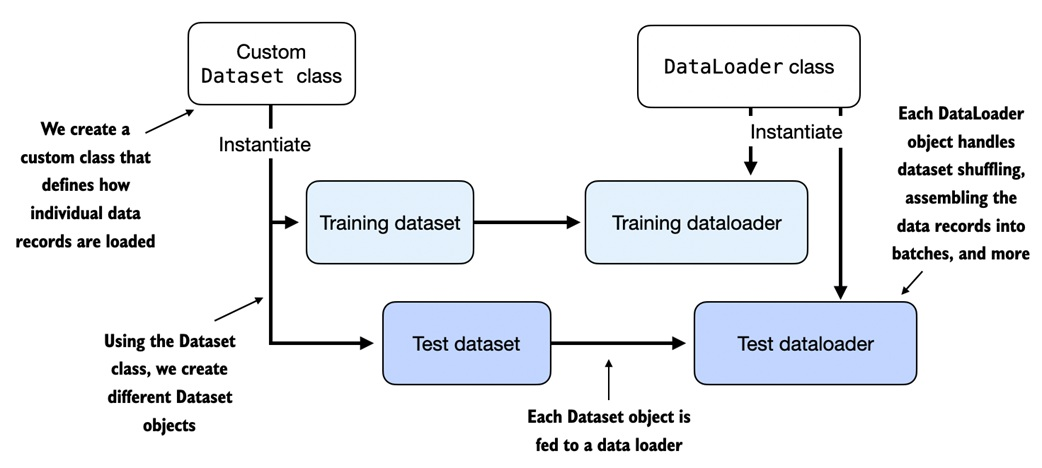


## 1. Dataset 类

- **作用**：用来定义“每条数据怎么被加载”。
- **怎么用**：你通常会写一个自己的 Dataset 类（比如继承 `torch.utils.data.Dataset`），告诉它怎么读取图片、文本等。
- **举个例子**：假如你有一个猫狗图片文件夹，你可以写个 Dataset 类，每次返回一张图片和它的标签。

在继承 Dataset 类时，必须实现以下两个方法：

__len__:

返回数据集的大小（样本数量）。
通过 len(dataset) 获取。
__getitem__:

根据索引 idx 返回对应的数据样本。
返回值通常是一个元组 (input, target)，用于训练模型。
支持通过索引访问样本数据，如 dataset[idx]。

---

## 2. DataLoader 类

- **作用**：用来“批量”加载数据，自动打包成 batch，还可以打乱顺序（shuffle），多线程读取等。
- **怎么用**：你把 Dataset 对象传给 DataLoader，然后 DataLoader 帮你搞定“每次取一批数据”。
- **举个例子**：你说 batch_size=32，DataLoader 每次就给你 32 张图片+标签。

---

## 图的流程

1. **自定义 Dataset 类**  
   你自己定义一个 Dataset 类，告诉 PyTorch 怎么读取一条数据。

2. **实例化 Dataset**  
   用这个类分别生成训练集和测试集的 Dataset 对象（比如 `train_dataset` 和 `test_dataset`）。

3. **实例化 DataLoader**  
   把 Dataset 对象传给 DataLoader，变成 `train_dataloader` 和 `test_dataloader`。

4. **DataLoader 工作**  
   DataLoader 会负责每次给你一批数据，可以自动打乱、批量、并行读取数据等等。

---

## 总结

- **Dataset**：管“一条数据怎么读”
- **DataLoader**：管“怎么一批批地读，还能打乱、加速等”
- 你先写 Dataset，再用它生成数据集，然后用 DataLoader 来喂给模型。


下面我们按照上图流程实现 PyTorch 的数据加载。  
首先创建一个自定义 Dataset 类，用它来生成训练集和测试集，然后创建相应的数据加载器。  
我们将从构建一个简单的玩具数据集开始，包含5个训练样本（每个有2个特征），对应的类别标签（3个属于类别0，2个属于类别1），以及2个测试样本。


In [3]:
import torch
# 创建一个小的玩具数据集
X_train = torch.tensor([
[-1.2, 3.1],
[-0.9, 2.9],
[-0.5, 2.6],
[2.3, -1.1],
[2.7, -1.5]
])

y_train = torch.tensor([0, 0, 0, 1, 1])

X_test = torch.tensor([
[-0.8, 2.8],
[2.6, -1.6],
])

y_test = torch.tensor([0, 1])

接下来，我们通过继承 PyTorch 的 Dataset 父类，创建一个自定义数据集类 ToyDataset，如下所示。

In [4]:
# Defining a custom Dataset class
from torch.utils.data import Dataset
class ToyDataset(Dataset):
  def __init__(self, X, y):
    self.features = X
    self.labels = y

  def __getitem__(self, index): #A
    one_x = self.features[index] #A
    one_y = self.labels[index] #A
    return one_x, one_y #A

  def __len__(self):
    return self.labels.shape[0] #B

train_ds = ToyDataset(X_train, y_train)
test_ds = ToyDataset(X_test, y_test)

这个自定义 ToyDataset 类的目的是用来实例化 PyTorch DataLoader。

在 PyTorch 中，自定义 Dataset 类的三个主要组件是：
1. **`__init__` 构造函数**：我们在这里设置以后可以在 `__getitem__` 和 `__len__` 方法中访问的属性。这些可以是文件路径、文件对象、数据库连接器等。由于我们创建的是存储在内存中的张量数据集，我们只是将 X 和 y 赋值给这些属性，它们是我们张量对象的占位符。

2. **`__getitem__` 方法**：我们在这里定义通过索引从数据集返回单个项目的指令。这意味着返回对应于单个训练样例或测试实例的特征和类别标签。(数据加载器将提供这个索引，稍后我们会介绍。)

3. **`__len__` 方法**：该方法包含获取数据集长度的指令。这里，我们使用张量的 `.shape` 属性来返回特征数组中的行数。

In [5]:
# 验证 __len__ 方法
print(len(train_ds))

5


现在我们已经为我们的玩具数据集定义了一个 PyTorch Dataset 类，我们可以使用 PyTorch 的 DataLoader 类从中进行采样

In [6]:
# Instantiating data loaders
#用 pytorch 自带的 DataLoader 采样
from torch.utils.data import DataLoader

#设置种子
torch.manual_seed(123)

#训练集采样
train_loader = DataLoader(
    dataset=train_ds, #A
    batch_size=2,
    shuffle=True, #B
    num_workers=0 #C
    )

#测试集采样
test_loader = DataLoader(
    dataset=test_ds,
    batch_size=2,
    shuffle=False, #D
    num_workers=0
    )

In [7]:
#展示下训练集采样结果
for idx, (x, y) in enumerate(train_loader):
  print(f"Batch {idx+1}:", x, y)

Batch 1: tensor([[ 2.3000, -1.1000],
        [-0.9000,  2.9000]]) tensor([1, 0])
Batch 2: tensor([[-1.2000,  3.1000],
        [-0.5000,  2.6000]]) tensor([0, 0])
Batch 3: tensor([[ 2.7000, -1.5000]]) tensor([1])


**enumerate 函数是什么？**  
作用：enumerate 用于在遍历（for 循环）一个可迭代对象（如列表、DataLoader等）时，同时获得元素的索引和值。

**基本用法（python）：**  
for idx, item in enumerate(some_list):  
    print(idx, item)  
这样每次循环可以同时得到当前元素的编号（idx）和内容（item）。

输出结果的含义

1. **train_loader 遍历训练集，每个样本只访问一次**
   - 也就是说，`train_loader` 会把训练集里的每个数据都拿出来用一遍，没有遗漏也没有重复。
   - 这一轮被称为一个“训练轮次”或者“训练周期”（英文叫 epoch）。

2. **设置了随机种子，打乱顺序是可复现的**
   - 用 `torch.manual_seed(123)` 固定了随机种子，这样你每次运行代码时，数据打乱（shuffle）的顺序都是一样的，方便对比和调试。

3. **每次新一轮 epoch，shuffle 顺序会变**
   - 如果你再用 `train_loader` 遍历一遍训练集（比如第2个 epoch），数据顺序会和第1轮不一样。
   - 也就是说，每个 epoch 都会把数据重新打乱。

4. **为什么要每轮都shuffle？**
   - 这样做的目的是防止神经网络陷入“重复的更新循环”。如果每次都按同样的顺序喂数据，模型可能学不到更泛化的规律。
   - 每轮都打乱顺序，可以让模型见到数据的排列更加多样化，有助于模型更好地训练和泛化。

---

### 总结

- **每次完整遍历训练数据叫做一个 epoch。**
- **每个 epoch 训练数据的顺序会被打乱（shuffle），而且每一轮 shuffle 的结果都不一样。**
- **这样能避免模型学到数据顺序里的“死记硬背”，让训练更有效。**

请注意，我们上面设置的 batch size（批大小）是 2，但是第三个 batch 只包含了一个样本。这是因为我们总共有 5 个训练样本，不能被 2 整除。实际上，如果在一个训练 epoch 的最后，最后一个 batch 明显比其他 batch 小，可能会影响训练过程中的收敛效果。为了避免这种情况，建议设置 drop_last=True，这样每个 epoch 的最后一个 batch 就会被丢弃，具体如下所示：

In [8]:
train_loader = DataLoader(
dataset=train_ds,
batch_size=2,
shuffle=True,
num_workers=0,
drop_last=True
)

In [9]:
for idx, (x, y) in enumerate(train_loader):
  print(f"Batch {idx+1}:", x, y)

Batch 1: tensor([[-1.2000,  3.1000],
        [-0.5000,  2.6000]]) tensor([0, 0])
Batch 2: tensor([[ 2.3000, -1.1000],
        [-0.9000,  2.9000]]) tensor([1, 0])


### num_workers 参数

#### 1. **num_workers=0 是什么？**
- 在 PyTorch 的 DataLoader 里有个参数叫 `num_workers`。
- 这个参数决定“有多少个进程用来并行加载和预处理数据”。
- 如果你把它设为 **0**，意思就是“**只有主进程（主程序）自己来加载数据**”，不会开新进程来帮忙。

#### 2. **num_workers=0 的问题**
- 这样做看起来没啥问题，实际却可能导致训练变慢，尤其是用 GPU 训练大模型时。
- 因为此时，CPU 既要管模型训练的协调，又要负责一条条地加载/处理数据，比较慢。
- GPU 在等待数据的时候就只能“干等着”，没法充分利用 GPU 的强大计算力。

#### 3. **num_workers>0 的好处**
- 如果你设置 `num_workers` 大于 0，比如 2、4、8 等，**DataLoader 会开多个子进程并行地帮你加载和预处理数据**。
- 这样主进程可以专心训练模型，数据也能被及时准备好，**CPU 和 GPU 的资源被更高效利用，训练速度就更快**。


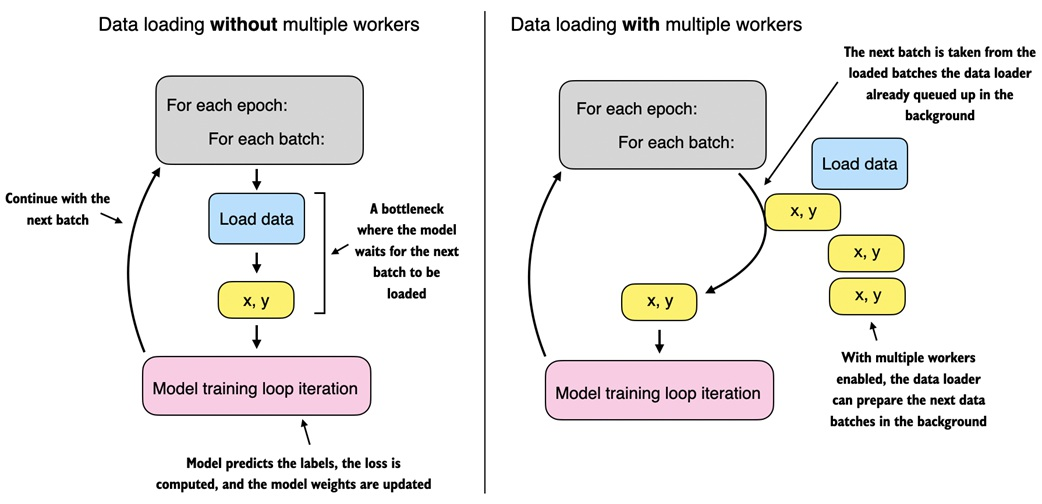

这张图直观地对比了 **num_workers=0** 和 **num_workers>0** 时数据加载的区别。

---

## 左图：没有多进程（num_workers=0）

- **流程**：每次训练模型前，先等着“加载数据”完毕，然后再开始用这一批数据训练。
- **问题**：模型训练完一批后，还得等下一批数据加载好，**模型经常在“等数据”，导致训练变慢**。
- **瓶颈**：数据加载慢，模型就只能干等。

---

## 右图：有多进程（num_workers>0）

- **流程**：数据加载和预处理有多个进程**同时在后台准备好好几批数据**。
- **好处**：模型只要训练完一批，**立马就有下一批数据可以用**，几乎没有等待时间。
- **高效**：训练和数据加载可以“并行”，CPU/GPU都能被更充分利用。

---

## 总结一句话

- **num_workers=0**：模型老是在等数据，训练速度慢。
- **num_workers>0**：数据提前准备好，模型几乎不停训练，速度快。

---


在不同情况下，`num_workers` 的选择要灵活，不是越大越好。

---

### 1. **小数据集没必要设置多进程**
- 如果你的数据集很小，训练只需要几秒钟甚至更短时间，那么设置 `num_workers=1` 或更大其实没啥意义。
- 因为数据都很快就加载完了，多开进程不会让速度变快。

### 2. **在 Jupyter Notebook 里开多进程反而可能有问题**
- 在 Jupyter Notebook 这种交互式环境下，`num_workers` 设置大于0，有时不仅提速不明显，反而可能导致一些问题，比如：
  - 开多个进程的“启动和管理”开销，比实际加载数据还慢；
  - 可能出现资源冲突、报错，甚至 notebook 崩溃。

### 3. **多进程也有“管理成本”**
- 如果数据集很小，多进程的启动、通讯等“管理成本”反而大于实际收益。

### 4. **怎么选合适的 num_workers？**
- 要根据你的数据集大小、代码环境（比如命令行还是 notebook）、硬件配置来灵活设置。
- 对于大数据集、正式训练，适当加大 `num_workers` 可以加速训练。
- 作者经验：**`num_workers=4` 在许多实际项目里表现不错**，但具体最优值还得看你的硬件和数据加载代码。

---

## 总结

> 小数据集或在 Jupyter notebook 里，不一定要开多进程；多进程适合大数据集和正式训练环境，具体数值要结合实际情况调整。


In [10]:
import tiktoken
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size, max_length, stride,
                         shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

vocab_size = 50257
output_dim = 256
context_length = 1024


token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

batch_size = 8
max_length = 4
dataloader = create_dataloader_v1(
    raw_text,
    batch_size=batch_size,
    max_length=max_length,
    stride=max_length
)

In [11]:
for batch in dataloader:
    x, y = batch

    token_embeddings = token_embedding_layer(x)
    pos_embeddings = pos_embedding_layer(torch.arange(max_length))

    input_embeddings = token_embeddings + pos_embeddings

    break

In [12]:
print(input_embeddings.shape)

torch.Size([8, 4, 256])
